# Challenge

Let's add a new feature:

- **Day of Week (Categorical)**

Consider these questions:

- How would you calculate this feature?
- How would you represent it in the data?
- Where would you store this feature?
- How would this feature affect your pipeline? What would you need to rework?

## Calculation

**Aggregate our data to a daily level**

In [1]:
import pandas as pd

csv_file_path = 'data/energy_data.csv'
df = pd.read_csv(csv_file_path, parse_dates=['period'])
df.set_index('period', inplace=True)
df_daily = df.resample('D').sum("value")
df_daily

,value
period,
2024-01-01,116406
2024-01-02,128866
2024-01-03,131883
2024-01-04,131606
2024-01-05,136960
...,...
2024-03-26,125493
2024-03-27,125867
2024-03-28,125577


**Version 1: Numerical representation**

Straightforward, but not necessarily ideal - you can only learn one parameter and it's actually a nominal scale, not ratio

In [2]:
batch_df = pd.DataFrame()
batch_df['day_of_week'] = df_daily.index.dayofweek
batch_df.head(10)

,day_of_week
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,0
8,1
9,2


**Version 2: One-Hot Encoding / Dummy Variables**

Lets you train one parameter per category, but increases complexity of data (new columns = category levels)

In [3]:
pd.get_dummies(batch_df['day_of_week'], dtype = int)

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
85,0,1,0,0,0,0,0
86,0,0,1,0,0,0,0
87,0,0,0,1,0,0,0
88,0,0,0,0,1,0,0


## Storing the feature

**Create a new feature store YAML with the new feature**

Note: ideally, just create a feature view (https://feast.dev/)

In [4]:
import os
import yaml
# Directory for feature store
directory = "feature_store"
if not os.path.exists(directory):
    os.makedirs(directory)

# Feature definitions
id = "v2"
config_data = {
    'feature_store': {
        'id': f"{id}",
        'latest_feature': "1999-01-01",
        'latest_target': "1999-01-01",
        'feature_offset': "13",
        'target_offset': "3",
        'features_path': f"feature_store/features_{id}.csv",
        'targets_path': f"feature_store/targets_v1.csv",
        'schema': {
            'features': [
                {'name': 'lag_1', 'type': 'float'},
                {'name': 'lag_4', 'type': 'float'},
                {'name': 'lag_5', 'type': 'float'},
                {'name': 'lag_6', 'type': 'float'},
                {'name': 'lag_11', 'type': 'float'},
                {'name': 'lag_12', 'type': 'float'},
                {'name': 'lag_13', 'type': 'float'},
                {'name': 'rolling_mean_7', 'type': 'float'},
                {'name': 'rolling_std_7', 'type': 'float'},
                {'name': 'day_of_week', 'type': 'int'} # new

            ],
            'targets': [
                {'name': 'target_1d', 'type': 'float'},
                {'name': 'target_2d', 'type': 'float'},
                {'name': 'target_3d', 'type': 'float'}
            ]
        }
    }
}

# Path to the YAML configuration file
yaml_file_path = os.path.join(directory, f'config_{id}.yaml')

# Write the configuration data to a YAML file
with open(yaml_file_path, 'w') as file:
    yaml.dump(config_data, file, default_flow_style=False)

**Update the feature pipeline by adding the new calculation**

In [5]:
def feature_pipeline(energy_data):
    df_daily = energy_data.resample('D').sum("value")

    batch_df = pd.DataFrame()

    # Lagging features
    batch_df['lag_1'] = df_daily['value'].shift(1) # Energy demand -1 day

    batch_df['lag_4'] = df_daily['value'].shift(4) # Energy demand +3 days - 7 days
    batch_df['lag_5'] = df_daily['value'].shift(5) # Energy demand +2 days - 7 days
    batch_df['lag_6'] = df_daily['value'].shift(6) # Energy demand +1 days - 7 days

    batch_df['lag_11'] = df_daily['value'].shift(11) # Energy demand +3 days - 14 days
    batch_df['lag_12'] = df_daily['value'].shift(12) # Energy demand +2 days - 14 days
    batch_df['lag_13'] = df_daily['value'].shift(13) # Energy demand +1 days - 14 days

    # Rolling statistics
    batch_df['rolling_mean_7'] = df_daily['value'].rolling(window=7).mean().round(2)
    batch_df['rolling_std_7'] = df_daily['value'].rolling(window=7).std().round(2)

    # Day of week
    batch_df['day_of_week'] = df_daily.index.dayofweek # new
    
    batch_df = batch_df.dropna()

    return batch_df

**Populate the new feature store with data from the new pipeline**

In [6]:
from scripts import feature_store
# Rebuild the feature store
batch_df = feature_pipeline(df)
feature_store.update_feature_store(batch_df, yaml_file_path)

Feature store updated with last date 2024-03-30 00:00:00


**Retrain the model given the new feature**

In [7]:
import xgboost as xgb

X_train = feature_store.fetch_data_from_store(yaml_file_path = yaml_file_path)
Y_train = feature_store.fetch_data_from_store(X_train.index.min(), yaml_file_path, targets = True)[:X_train.index.max()]

y_train_ls= []
for target in Y_train.columns:
  y_train_ls.append(Y_train[target])

cv_results_ls = []
for y_train in y_train_ls:
  dtrain = xgb.DMatrix(data=X_train, label=y_train)
  params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
  }

  # Perform cross-validation
  cv_results = xgb.cv(
      params=params,
      dtrain=dtrain,
      num_boost_round=999,
      nfold = 5,
      early_stopping_rounds=10,
      metrics='rmse',
      as_pandas=True,
      seed=123
  )
  cv_results_ls.append(cv_results)
  print(f"Last mean RMSE: {cv_results['test-rmse-mean'].min()}")

final_models_ls = []

for cv_results, y_train in zip(cv_results_ls, y_train_ls):
    optimal_boost_rounds = cv_results['test-rmse-mean'].idxmin() + 1
    final_model = xgb.XGBRegressor(
        n_estimators=optimal_boost_rounds,
        **params
    )
    final_model.fit(X_train, y_train)
    final_models_ls.append(final_model)

Last mean RMSE: 6988.235825914405
Last mean RMSE: 7208.114646756362
Last mean RMSE: 7770.229219022871


**Check the model performance visually**

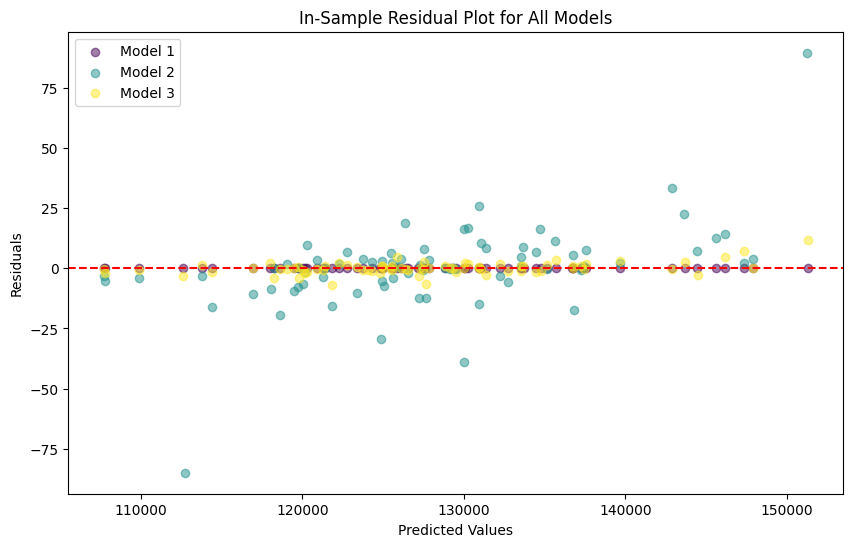

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Generate residual plot

# Initialize lists to hold all predicted values and residuals
all_y_pred = []
all_residuals = []

# Generate a list of colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(final_models_ls)))

# Plot residuals for each model
plt.figure(figsize=(10, 6))

for idx, (final_model, y_train) in enumerate(zip(final_models_ls, y_train_ls)):
    # Make predictions
    y_pred = final_model.predict(X_train)

    # Calculate residuals
    residuals = y_train - y_pred

    # Plot residuals with a unique color for each model
    plt.scatter(y_pred, residuals, color=colors[idx], alpha=0.5, label=f'Model {idx+1}')

# Add plot title and labels
plt.axhline(y=0, color='red', linestyle='--')
plt.title('In-Sample Residual Plot for All Models')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()  # Add a legend to differentiate each model
plt.show()

Diagnostic: Overfitting for Model 3

**Save the new models**

In [9]:
import joblib

# Save each model with a unique filename
for idx, final_model in enumerate(final_models_ls):
    filename = f'models/batch_demand_forecaster_model_{idx+1}_{id}.pkl'  # Create a unique filename for each model
    joblib.dump(final_model, filename)